<center><img src="https://news.illinois.edu/files/6367/543635/116641.jpg" alt="University of Illinois" width="250"/></center>

# STAT542: Statistical Learning

## Final Project ##

* Yu-Ching Liao <ycliao3@illinois.edu>

# Basic Import

In [1]:
import pandas as pd
import numpy as np
from surprise import Dataset, Reader, SVD, NMF, KNNWithMeans
from surprise.model_selection import cross_validate
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_absolute_percentage_error as MAPE

# Reading Data

In [2]:
# Load the data
csv_data = pd.read_csv("Training_set.csv")
display(csv_data.head())

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15
0,NaN,3.0,NaN,3.0,NaN,3.0,5.0,NaN,3.0,4.0,NaN,5.0,5.0,3.0,NaN
1,4.0,NaN,5.0,5.0,2.0,NaN,1.0,NaN,4.0,NaN,NaN,5.0,NaN,5.0,3.0
2,3.0,3.0,NaN,NaN,3.0,3.0,NaN,NaN,1.0,3.0,NaN,4.0,3.0,NaN,3.0
3,NaN,4.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,3.0,3.0,NaN,NaN,2.0,NaN
4,NaN,NaN,NaN,NaN,5.0,NaN,5.0,NaN,NaN,3.0,4.0,NaN,NaN,2.0,NaN


# Algorithm

## Singular Value Decomposition (SVD)

In [28]:
def iterative_svd(A, A_star, k, tol=1e-6, max_iter=1000):
    mask = np.isnan(A)
    A_filled = np.where(mask, A_star, A)
    prev_A_filled = np.zeros(A_filled.shape)
    iteration = 0
    
    while np.linalg.norm(A_filled - prev_A_filled) > tol and iteration < max_iter:
        iteration += 1
        prev_A_filled = A_filled.copy()
        U, s, Vt = np.linalg.svd(A_filled, full_matrices=False)
        
        # Truncate U, S, and Vt to only keep the k largest singular values
        U = U[:, :k]
        s = s[:k]
        Vt = Vt[:k, :]
        
        S = np.diag(s)
        A_filled = U.dot(S).dot(Vt)
        A_filled = np.where(mask, A_filled, A)
        

    return A_filled

## K-Nearest Neighbors (KNN)

In [53]:
def KNN_model(criteria, whom_based):  

    if whom_based == "item":
        max_k = 16
        based = False
    else:
        max_k = 51
        based = True

    

    # Transform the data into a list of tuples (user_id, video_id, rating)
    data = [
        (user_id, video_id, rating)
        for user_id, row in csv_data.iterrows()
        for video_id, rating in enumerate(row, start=1)
        if not pd.isna(rating)
    ]

    # Define the reader to specify the rating_scale
    reader = Reader(rating_scale=(1, 5))

    # Create the dataset
    dataset = Dataset.load_from_df(pd.DataFrame(data, columns=["user_id", "video_id", "rating"]), reader)


    # Load the answer.csv file
    answer_data = pd.read_csv("Answers.csv")

    # Define the range of k values to try
    k_values = list(range(1, max_k))

    # Initialize variables to store the best k and the lowest RMSE
    best_k = None
    lowest_rmse = float('inf')

    # Initialize a list to store RMSE values for each k
    rmse_values = []

    for k in k_values:
        # Train the KNNWithMeans algorithm with the current k value
        # item based, using pearson based similarity
        knn = KNNWithMeans(k=k, verbose=False, sim_options={'name': criteria, 'user_based': based})
        trainset = dataset.build_full_trainset()
        knn.fit(trainset)

        # Fill the missing values in the dataset
        filled_data = csv_data.copy()
        for user_id, row in csv_data.iterrows():
            for video_id, rating in enumerate(row, start=1):
                if pd.isna(rating):
                    prediction = knn.predict(user_id, video_id)
                    filled_data.at[user_id, f'V{video_id}'] = prediction.est

        # Calculate the root mean squared error (RMSE)
        rmse = np.sqrt(MSE(filled_data, answer_data))
        rmse_values.append(rmse)

        # Update the best k and the lowest RMSE if the current RMSE is lower than the previous lowest RMSE
        if rmse < lowest_rmse:
            best_k = k
            lowest_rmse = rmse
            lowest_mse = MSE(filled_data, answer_data)
            lowest_mae = MAE(filled_data, answer_data)
            lowest_mape = MAPE(filled_data, answer_data)

    '''
    # Plot the RMSE values for each k
    plt.figure(figsize=(10, 6))
    plt.scatter(k_values, rmse_values, label='RMSE')
    plt.scatter(best_k, lowest_rmse, color='red', label=f'Best k: {best_k}')

    # Add labels and a legend
    plt.xlabel('k value')
    plt.ylabel('RMSE')
    plt.title(f'KNN: RMSE for Different k Values {criteria} / {whom_based}')
    plt.legend()

    # Show the plot
    plt.show()
    '''

    print(f"KNN, criteria: {criteria}, {whom_based} based. ")
    print(f"The best k value is: {best_k}.")
    print(f"The Mean Squared Error (MSE) is: {lowest_mse}")
    print(f"The Root Mean Squared Error (RMSE) is: {lowest_rmse}")
    print(f"The Mean Absolute Error (MAE) is: {lowest_mae}")
    print(f"The Mean Absolute Percentage Error (MAPE) is: {lowest_mape}%")

    knn = KNNWithMeans(k=best_k, verbose=False, sim_options={'name': criteria, 'user_based': based})
    trainset = dataset.build_full_trainset()
    knn.fit(trainset)

    # Fill the missing values in the dataset
    filled_data = csv_data.copy()
    for user_id, row in csv_data.iterrows():
        for video_id, rating in enumerate(row, start=1):
            if pd.isna(rating):
                prediction = knn.predict(user_id, video_id)
                filled_data.at[user_id, f'V{video_id}'] = prediction.est
    filled_data.to_csv(str(best_k)+"NN_filled_data_" + criteria + "_" + whom_based + ".csv", index=False)
    return lowest_mse


# Iterations

In [50]:
# training set
csv_data = pd.read_csv("Training_set.csv")

# filling 3
filled_data_3 = csv_data.fillna(3)

# filling row mean
filled_data_row_mean = csv_data.apply(lambda row: row.fillna(row.mean()), axis=1)

# filling column mena
filled_data_col_mean = csv_data.apply(lambda col: col.fillna(col.mean()), axis=0)

# filling with best item-based  KNN 
filled_data_item_KNN = pd.read_csv("11NN_filled_data_msd_item.csv")

#filling with best user-based KNN
filled_data_user_KNN = pd.read_csv("22NN_filled_data_msd_user.csv")

# answer sheet
answer_data = pd.read_csv("Answers.csv")

In [54]:
l = []

initializing_df = ["3", "row_mean", "column_mean", "item_KNN", "user_KNN"]
criterias = ["cosine", "pearson", "msd"]
whom_baseds = ["item", "user"]
files = ["8NN_filled_data_cosine_item.csv", "7NN_filled_data_pearson_item.csv", 
         "11NN_filled_data_msd_item.csv", "11NN_filled_data_pearson_user.csv", 
         "22NN_filled_data_msd_user.csv", "26NN_filled_data_cosine_user.csv"]

mse = MSE(answer_data , iterative_svd(csv_data.to_numpy(), filled_data_3.to_numpy(),14))
mape = MAPE(answer_data , iterative_svd(csv_data.to_numpy(), filled_data_3.to_numpy(),14))
rmse = np.sqrt(mse)
mae = MAE(answer_data , iterative_svd(csv_data.to_numpy(), filled_data_3.to_numpy(),14))
l.append(mse)


print(f"SVD, initiated with filling 3.")
print(f"The Mean Squared Error (MSE) is: {mse}")
print(f"The Root Mean Squared Error (RMSE) is: {rmse}")
print(f"The Mean Absolute Error (MAE) is: {mae}")
print(f"The Mean Absolute Percentage Error (MAPE) is: {mape}%")
print("----------------------------------------------------------------------------------")
mse = MSE(answer_data , iterative_svd(csv_data.to_numpy(), filled_data_row_mean.to_numpy(),14))
mape = MAPE(answer_data , iterative_svd(csv_data.to_numpy(), filled_data_row_mean.to_numpy(),14))
rmse = np.sqrt(mse)
mae = MAE(answer_data , iterative_svd(csv_data.to_numpy(), filled_data_row_mean.to_numpy(),14))
l.append(mse)

print(f"SVD, initiated with filling row mean.")
print(f"The Mean Squared Error (MSE) is: {mse}")
print(f"The Root Mean Squared Error (RMSE) is: {rmse}")
print(f"The Mean Absolute Error (MAE) is: {mae}")
print(f"The Mean Absolute Percentage Error (MAPE) is: {mape}%")
print("----------------------------------------------------------------------------------")
mse = MSE(answer_data , iterative_svd(csv_data.to_numpy(), filled_data_col_mean.to_numpy(),14))
mape = MAPE(answer_data , iterative_svd(csv_data.to_numpy(), filled_data_col_mean.to_numpy(),14))
rmse = np.sqrt(mse)
mae = MAE(answer_data , iterative_svd(csv_data.to_numpy(), filled_data_col_mean.to_numpy(),14))
l.append(mse)

print(f"SVD, initiated with filling column mean.")
print(f"The Mean Squared Error (MSE) is: {mse}")
print(f"The Root Mean Squared Error (RMSE) is: {rmse}")
print(f"The Mean Absolute Error (MAE) is: {mae}")
print(f"The Mean Absolute Percentage Error (MAPE) is: {mape}%")
print("----------------------------------------------------------------------------------")
print("----------------------------------------------------------------------------------")

for criteria in criterias:
    for whom_based in whom_baseds:
        mse = KNN_model(criteria, whom_based)
        l.append(mse)
        print("----------------------------------------------------------------------------------")
print("----------------------------------------------------------------------------------")

for file in files: 
    filled_data = pd.read_csv(file)
    mse = MSE(answer_data , iterative_svd(csv_data.to_numpy(), filled_data.to_numpy(),14))
    mape = MAPE(answer_data , iterative_svd(csv_data.to_numpy(), filled_data.to_numpy(),14))
    rmse = np.sqrt(mse)
    mae = MAE(answer_data , iterative_svd(csv_data.to_numpy(), filled_data.to_numpy(),14))
    l.append(mse)

    print(f"SVD, initiated with filling {file}.")
    print(f"The Mean Squared Error (MSE) is: {mse}")
    print(f"The Root Mean Squared Error (RMSE) is: {rmse}")
    print(f"The Mean Absolute Error (MAE) is: {mae}")
    print(f"The Mean Absolute Percentage Error (MAPE) is: {mape}%")
    print("----------------------------------------------------------------------------------")

print("----------------------------------------------------------------------------------")
training_data = pd.read_csv("Training_set.csv")
mean_value = training_data.stack().mean()
filled_with_mean = training_data.fillna(mean_value)

# Calculate the mean squared error (MSE)
mse = MSE(filled_with_mean, answer_data)
l.append(mse)

# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(mse)

# Calculate the mean absolute error (MAE)
mae = MAE(filled_with_mean, answer_data)

# Calculate the mean absolute percentage error (MAPE)
mape = MAPE(filled_with_mean, answer_data)
print(f"Simply filling with mean of all value.")
print(f"The Mean Squared Error (MSE) is: {mse}")
print(f"The Root Mean Squared Error (RMSE) is: {rmse}")
print(f"The Mean Absolute Error (MAE) is: {mae}")
print(f"The Mean Absolute Percentage Error (MAPE) is: {mape}%")

SVD, initiated with filling 3.
The Mean Squared Error (MSE) is: 0.523572142527335
The Root Mean Squared Error (RMSE) is: 0.7235828511838399
The Mean Absolute Error (MAE) is: 0.3575679904598205
The Mean Absolute Percentage Error (MAPE) is: 0.12164013209418316%
----------------------------------------------------------------------------------
SVD, initiated with filling row mean.
The Mean Squared Error (MSE) is: 0.4496513387729265
The Root Mean Squared Error (RMSE) is: 0.670560466157174
The Mean Absolute Error (MAE) is: 0.36446075487721485
The Mean Absolute Percentage Error (MAPE) is: 0.1379858740857598%
----------------------------------------------------------------------------------
SVD, initiated with filling column mean.
The Mean Squared Error (MSE) is: 0.4118174565042793
The Root Mean Squared Error (RMSE) is: 0.6417300495568828
The Mean Absolute Error (MAE) is: 0.3491779901725636
The Mean Absolute Percentage Error (MAPE) is: 0.13449483603101936%
------------------------------------

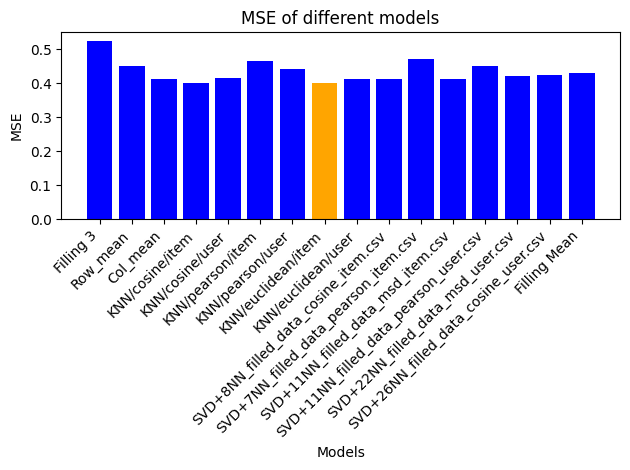

In [55]:
labels = ['Filling 3', 'Row_mean', 'Col_mean', 'KNN/cosine/item', 'KNN/cosine/user',
          'KNN/pearson/item', 'KNN/pearson/user', 'KNN/euclidean/item', 'KNN/euclidean/user',
          "SVD+8NN_filled_data_cosine_item.csv", "SVD+7NN_filled_data_pearson_item.csv", 
         "SVD+11NN_filled_data_msd_item.csv", "SVD+11NN_filled_data_pearson_user.csv", 
         "SVD+22NN_filled_data_msd_user.csv", "SVD+26NN_filled_data_cosine_user.csv", 'Filling Mean']


# Find the index of the lowest bar
lowest_index = l.index(min(l))

# Set the default color for all bars
colors = ['blue' for _ in range(len(l))]

# Change the color of the lowest bar to orange
colors[lowest_index] = 'orange'

# Create the bar plot with custom colors
plt.bar(labels, l, color=colors)

# Rotate the x-axis labels
plt.xticks(rotation=45, ha='right')

plt.ylabel("MSE")
plt.xlabel("Models")
plt.title("MSE of different models")

plt.tight_layout()  # This will help adjust the layout to better fit the labels
plt.show()


<center><img src="https://news.illinois.edu/files/6367/543635/116641.jpg" alt="University of Illinois" width="250"/></center>